# 텐서플로 시작하기
- p120

## 상수 텐서와 변수
- 모두 1이거나 0인 텐서를 만들자

In [1]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
x

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [2]:
x = tf.zeros(shape=(2, 1))
x

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>

## 랜덤 텐서

In [3]:
x = tf.random.normal(shape=(3, 1), mean = 0., stddev= 1.)
print(x)

tf.Tensor(
[[-0.8598972]
 [ 0.9767888]
 [-1.6645002]], shape=(3, 1), dtype=float32)


In [4]:
x = tf.random.uniform(shape=(3, 1), minval = 0., maxval=1.)
print(x)

tf.Tensor(
[[0.6805692 ]
 [0.20835924]
 [0.9026166 ]], shape=(3, 1), dtype=float32)


## 값 할당

In [5]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.
x

array([[0., 1.],
       [1., 1.]])

In [6]:
x = tf.ones(shape=(2, 2))
x[0, 0] = 0. # 할당 없음

TypeError: ignored

In [7]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 1.7674061 ],
       [-0.41718715],
       [-0.6775516 ]], dtype=float32)>


In [8]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [9]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

In [10]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

## 텐서 연산 : 텐서플로에서 사칙연산

In [11]:
a = tf.ones((2, 2))
b = tf.square(a) # 제곱 계산
c = tf.sqrt(a) # 제곱근 계산
d = b + c # 두 텐서 더하기
e = tf.matmul(a, d)
e *= d
e

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[8., 8.],
       [8., 8.]], dtype=float32)>

# GradientTape API 살펴보기
- 텐서플로 numpy와 비슷
  + 미분가능하게 만들어줌 (텐서플로 O, numpy X)

In [12]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

In [13]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

In [14]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

# 엔드-투-엔드 예제
- 텐서플로 선형 분류기


## 2D 평면에 두 클래스 데이터 생성

In [15]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean = [0, 3], # x축의 위치를 살짝 조정
    cov = [[1, 0.5], [0.5, 1]], # 데이터 방향이 우상향
    size = num_samples_per_class
)

positive_samples = np.random.multivariate_normal(
    mean = [3, 0], # x축의 위치를 살짝 조정
    cov = [[1, 0.5], [0.5, 1]], # 데이터 방향이 우상향
    size = num_samples_per_class
)

In [16]:
positive_samples.dtype

dtype('float64')

## 두 데이터 합치기

In [17]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
inputs.shape

(2000, 2)

## 0과 1로 구성된 타겟 생성

In [18]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))
targets.shape

(2000, 1)

## 그래프 그려보기

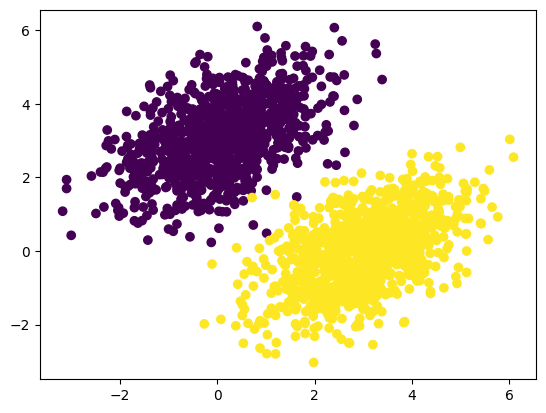

In [19]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

p.127
- 선형 분류기
  = prediction = w * input + b

In [20]:
input_dim = 2 # 입력은 2차원 배열
output_dim = 1 # 출력 예측은 하나의 점수, 0에 가까우면 0, 1에 가까우면 1
W = tf.Variable(initial_value = tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value = tf.zeros(shape=(output_dim, )))

## 정방향 패스 함수

In [21]:
def model(inputs):
  return tf.matmul(inputs, W) + b

## 평균 제곱 오차 손실 함수

In [22]:
def square_loss(targets, predictions):
  per_sample_losses = tf.square(targets - predictions) # 각 샘플의 손실 값을 담고 있다.
  return tf.reduce_mean(per_sample_losses) # 샘플당 손실 값으로 하나의 스칼라 손실 값으로 평균

## 훈련 스텝 함수
- 순전파 계산(=정방향 계산)
- 역전파 계산
- 가중치를 업데이트 = 기울기 변동 = 오차를 감소시키기 위한 목적

In [23]:
learning_rate = 0.1 # step
def training_step(inputs, targets):
  with tf.GradientTape() as tape: # 정방향 계산, 순전파 계산
    predictions = model(inputs)
    loss = square_loss(targets, predictions)
  # 역전파 수행 중, 각각의 업데이트 된 기울기(=가중치)
  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
  W.assign_sub(grad_loss_wrt_W * learning_rate) # 가중치 업데이트
  b.assign_sub(grad_loss_wrt_b * learning_rate) # 회귀식으로 따지면 절편

  return loss

## 배치 훈련 루프

In [24]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"{step}번째 스텝의 손실: {loss:.4f}")

0번째 스텝의 손실: 0.3229
1번째 스텝의 손실: 0.1263
2번째 스텝의 손실: 0.0961
3번째 스텝의 손실: 0.0869
4번째 스텝의 손실: 0.0811
5번째 스텝의 손실: 0.0762
6번째 스텝의 손실: 0.0718
7번째 스텝의 손실: 0.0677
8번째 스텝의 손실: 0.0640
9번째 스텝의 손실: 0.0607
10번째 스텝의 손실: 0.0576
11번째 스텝의 손실: 0.0548
12번째 스텝의 손실: 0.0523
13번째 스텝의 손실: 0.0499
14번째 스텝의 손실: 0.0478
15번째 스텝의 손실: 0.0459
16번째 스텝의 손실: 0.0441
17번째 스텝의 손실: 0.0425
18번째 스텝의 손실: 0.0410
19번째 스텝의 손실: 0.0396
20번째 스텝의 손실: 0.0384
21번째 스텝의 손실: 0.0373
22번째 스텝의 손실: 0.0363
23번째 스텝의 손실: 0.0353
24번째 스텝의 손실: 0.0345
25번째 스텝의 손실: 0.0337
26번째 스텝의 손실: 0.0330
27번째 스텝의 손실: 0.0323
28번째 스텝의 손실: 0.0317
29번째 스텝의 손실: 0.0312
30번째 스텝의 손실: 0.0307
31번째 스텝의 손실: 0.0302
32번째 스텝의 손실: 0.0298
33번째 스텝의 손실: 0.0295
34번째 스텝의 손실: 0.0291
35번째 스텝의 손실: 0.0288
36번째 스텝의 손실: 0.0285
37번째 스텝의 손실: 0.0282
38번째 스텝의 손실: 0.0280
39번째 스텝의 손실: 0.0278


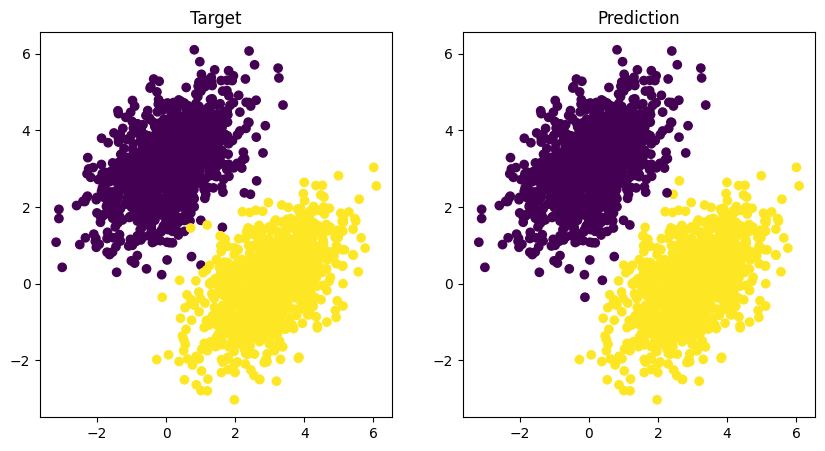

In [25]:
predictions = model(inputs)

fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))

ax[0].scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
ax[0].set_title("Target")
ax[1].scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
ax[1].set_title("Prediction")
plt.show()

## 직선 긋기

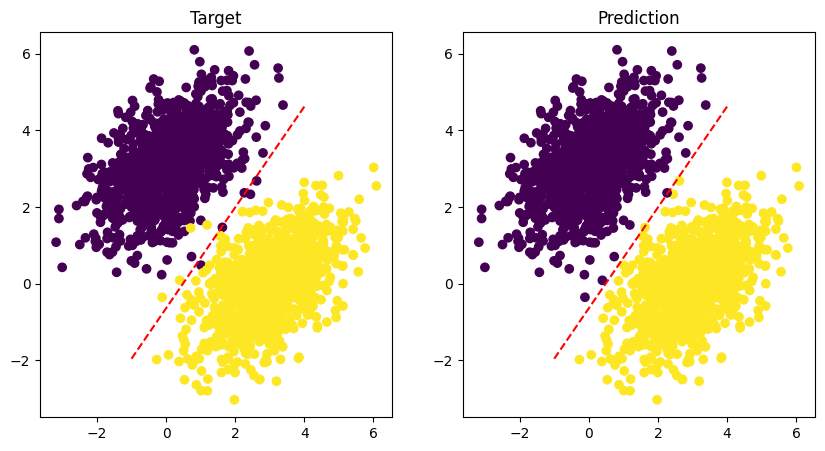

In [26]:
x = np.linspace(-1, 4, 100)
# 사실 100개의 x 축 좌표를 만들 필요 없이 시작과 종료 위치만 있어도 됩니다.
# x = [-1, 4]
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]

fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))

ax[0].scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
ax[0].set_title("Target")
ax[0].plot(x, y, '--r')
ax[1].scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
ax[1].set_title("Prediction")
ax[1].plot(x, y, '--r')
plt.show()

# 영화 리뷰 분류 : 이진 분류 문제
- p.147

In [27]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


In [28]:
train_data[0][:3] # 형태소 분석, 텍스트 마이닝 할 때 나오는 숫자 개념

[1, 14, 22]

In [29]:
train_labels[0] # 부정적인 문장 0, 긍정적인 문장 1

1

In [30]:
len(train_data[0]), len(train_data[1])

(218, 189)

In [31]:
max([max(sequence) for sequence in train_data]) # 가장 자주 등장하는 단어 1만개로 제한

9999

In [32]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])

decode_review = " ".join(
    [reverse_word_index.get(i-3, "?") for i in train_data[1]]
)

decode_review

1641221/1641221 [==============================] - 0s 0us/step


"? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

## 정수 시퀀스를 멀티-핫 인코딩으로 인코딩
- p.149
  + 텍스트 데이터는, 문장 길이가 다 달라서, 바로 행렬로 변환이 어렵다
    + 방법 1: 같은 길이가 되도록 리스트에 패딩0을 추가
    + 방법 2: 멀티- 핫 인코딩, 0과 1의 벡터로 변환

In [33]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    for j in sequence:
      results[i, j] = 1.

  return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [34]:
len(train_data[0]), len(train_data[1])

(218, 189)

In [35]:
len(x_train[0]), len(x_train[1])

(10000, 10000)

In [36]:
x_train.shape

(25000, 10000)

In [37]:
x_test.shape

(25000, 10000)

## y값 벡터 변환

In [38]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

## 신경망 모델 만들기
- Dense 층을 쌓기
  + 얼마나 많은 층을 사용할 것인가?
  + 각층에 얼마나 많은 은닉층을 사용할 것인가?
  + 얼마나 많은 unit

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# 모델 컴파일하기
model.compile(
    optimizer="rmsprop", # SGD 확률적 경사하강법
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

## 훈련 검증

In [40]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## 모델 훈련

In [41]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 4s 57ms/step - loss: 0.5837 - accuracy: 0.7581 - val_loss: 0.4714 - val_accuracy: 0.8331
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.3854 - accuracy: 0.8853 - val_loss: 0.3505 - val_accuracy: 0.8785
Epoch 3/20
30/30 [==============================] - 1s 38ms/step - loss: 0.2839 - accuracy: 0.9109 - val_loss: 0.3027 - val_accuracy: 0.8858
Epoch 4/20
30/30 [==============================] - 1s 41ms/step - loss: 0.2290 - accuracy: 0.9247 - val_loss: 0.2827 - val_accuracy: 0.8912
Epoch 5/20
30/30 [==============================] - 1s 38ms/step - loss: 0.1944 - accuracy: 0.9346 - val_loss: 0.2888 - val_accuracy: 0.8848
Epoch 6/20
30/30 [==============================] - 1s 41ms/step - loss: 0.1647 - accuracy: 0.9465 - val_loss: 0.2809 - val_accuracy: 0.8875
Epoch 7/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1436 - accuracy: 0.9547 - val_loss: 0.2909 - val_accuracy: 0.8858
Epoch 8/20
30

In [42]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## 훈련과 검증 손실 그리기
- 해당 코드 함수화 할 것
  + 미니 과제

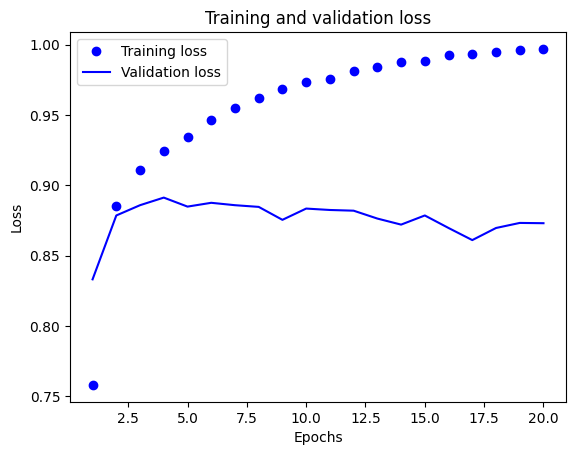

In [43]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["accuracy"]
val_loss_values = history_dict["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 뉴스 기사 분류 : 다중분류 문제
- p.160, 1986년 로이터 데이터셋
- 46개의 토픽 존재
- 10개의 샘플 존재

In [44]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = 10000)

2110848/2110848 [==============================] - 0s 0us/step


In [45]:
len(train_data)

8982

In [46]:
len(test_data)

2246

In [47]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

## 디코딩

In [48]:
word_index = reuters.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])

decode_newswire = " ".join(
    [reverse_word_index.get(i-3, "?") for i in train_data[0]]
)

decode_newswire

550378/550378 [==============================] - 0s 0us/step


'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [49]:
train_labels # 토픽의 인덱스가 0~45 사이 정수

array([ 3,  4,  3, ..., 25,  3, 25])

## 인코딩
- (비유적) 독립변수 전체를 벡터 변환

In [50]:
x_train = vectorize_sequences(train_data) # 훈련 데이터 벡터 변환
x_test = vectorize_sequences(test_data) # 훈련 데이터 벡터 변환

- 종속변수 전체 인코딩 ==> 범주형 인코딩

In [51]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [52]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

y_train.shape, y_test.shape #

((8982, 46), (2246, 46))

In [53]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## 모델 만들기

In [54]:
from tensorflow import keras
from tensorflow.keras import layers

"""
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid") # 이진분류 # 출력노드
])
"""

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax") # 3개이상 분류로 넘어가면 softmax (출력노드)
])

# 모델 컴파일하기 (p.163)
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy", # y_train = to_categorical(train_labels)
              metrics=["accuracy"])

## 검증 세트 준비하기

In [55]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

## 모델 훈련하기

In [56]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 5, # 20
                    batch_size = 512,
                    validation_data = (x_val, y_val))

Epoch 1/5
16/16 [==============================] - 2s 42ms/step - loss: 2.8587 - accuracy: 0.4386 - val_loss: 1.9692 - val_accuracy: 0.6270
Epoch 2/5
16/16 [==============================] - 0s 22ms/step - loss: 1.6064 - accuracy: 0.6736 - val_loss: 1.4098 - val_accuracy: 0.6930
Epoch 3/5
16/16 [==============================] - 0s 21ms/step - loss: 1.1928 - accuracy: 0.7388 - val_loss: 1.2056 - val_accuracy: 0.7330
Epoch 4/5
16/16 [==============================] - 0s 21ms/step - loss: 0.9670 - accuracy: 0.7849 - val_loss: 1.0899 - val_accuracy: 0.7580
Epoch 5/5
16/16 [==============================] - 0s 21ms/step - loss: 0.7981 - accuracy: 0.8272 - val_loss: 0.9958 - val_accuracy: 0.7860


## 훈련 / 검증 손실 그리기

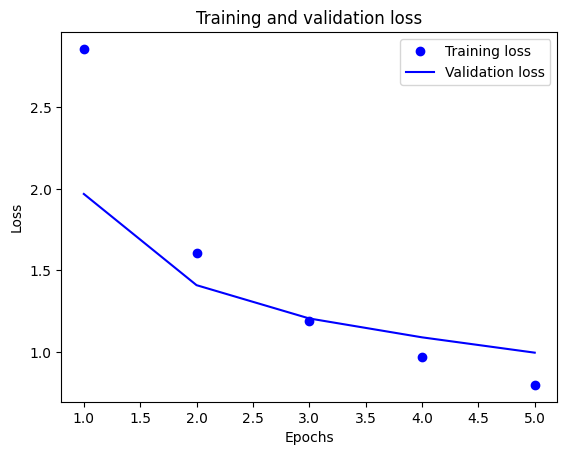

In [57]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 모델 재훈련

In [58]:
model.fit(partial_x_train,
          partial_y_train,
          epochs = 5,
          batch_size = 512,
          validation_data = (x_val, y_val))

Epoch 1/5
16/16 [==============================] - 0s 24ms/step - loss: 0.6624 - accuracy: 0.8569 - val_loss: 0.9468 - val_accuracy: 0.8070
Epoch 2/5
16/16 [==============================] - 0s 19ms/step - loss: 0.5507 - accuracy: 0.8829 - val_loss: 0.9240 - val_accuracy: 0.7980
Epoch 3/5
16/16 [==============================] - 0s 16ms/step - loss: 0.4652 - accuracy: 0.9019 - val_loss: 0.8895 - val_accuracy: 0.8160
Epoch 4/5
16/16 [==============================] - 0s 19ms/step - loss: 0.3941 - accuracy: 0.9169 - val_loss: 0.9130 - val_accuracy: 0.8130
Epoch 5/5
16/16 [==============================] - 0s 19ms/step - loss: 0.3333 - accuracy: 0.9296 - val_loss: 0.8825 - val_accuracy: 0.8210


In [59]:
results = model.evaluate(x_test, y_test)
results

71/71 [==============================] - 0s 4ms/step - loss: 0.9600 - accuracy: 0.7845


[0.9600414037704468, 0.7845057845115662]

- 랜덤 분류기

In [60]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.18744434550311664

## 예측

In [61]:
predictions = model.predict(x_test)
predictions[0].shape

71/71 [==============================] - 0s 3ms/step


(46,)

In [62]:
np.sum(predictions[0])

1.0000001

In [63]:
np.argmax(predictions[0])

3

In [64]:
y_train = np.array(train_labels) # 정수형태로 설정
y_test = np.array(test_labels) # 정수형태로 설정

y_train.shape, y_test.shape # 1차원 배열

((8982,), (2246,))

In [65]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [66]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax") # 3개이상 분류로 넘어가면 softmax (출력노드)
])

# 모델 컴파일하기 (p.163)
model.compile(optimizer="rmsprop",
              # loss="categorical_crossentropy", # 2차원 배열
              loss="sparse_categorical_crossentropy", # 1차원 배열, np.array(train_labels)
              metrics=["accuracy"])

model.fit(partial_x_train,
          partial_y_train,
          epochs = 5,
          batch_size = 512,
          validation_data = (x_val, y_val))

Epoch 1/5
16/16 [==============================] - 1s 29ms/step - loss: 2.7761 - accuracy: 0.5075 - val_loss: 1.9091 - val_accuracy: 0.6220
Epoch 2/5
16/16 [==============================] - 0s 17ms/step - loss: 1.6167 - accuracy: 0.6724 - val_loss: 1.4627 - val_accuracy: 0.6890
Epoch 3/5
16/16 [==============================] - 0s 18ms/step - loss: 1.2485 - accuracy: 0.7264 - val_loss: 1.2504 - val_accuracy: 0.7280
Epoch 4/5
16/16 [==============================] - 0s 18ms/step - loss: 1.0187 - accuracy: 0.7781 - val_loss: 1.1301 - val_accuracy: 0.7590
Epoch 5/5
16/16 [==============================] - 0s 17ms/step - loss: 0.8457 - accuracy: 0.8187 - val_loss: 1.0388 - val_accuracy: 0.7790


# 주택 가격 예측: 회귀 문제
- 1970년 중반 보스턴 외곽지역의 범죄율
- 각 특성

In [67]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [68]:
train_data.shape

(404, 13)

In [69]:
test_data.shape

(102, 13)

In [70]:
train_targets # 개별적인 수치 데이터

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## 데이터 준비
- 정규화하기 : 상이한 스케일을 가진 값을 신경망에 주입하면 문제가 됨
- 질문 : 왜 테스트 데이터에 train의 평균과 표준편차를 적용했는가?
- Data Leakage 반드시 공부!!
  + 훈련 데이터 / 검증 데이터 / 테스트 데이터 의미만 잘 기억!

In [71]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

## 모델 구성
- 샘플개수가 적기 때문에 2개의 중간

In [72]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(1) # 수치 데이터 하나만 예측
  ])
  model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
  return model

## K-겹 검증 훈련 검증
- p.173

In [73]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print(f'#{i+1} 번째 폴드 처리중')
  # print(i * num_val_samples, (i+1) * num_val_samples)
  val_data = train_data[i * num_val_samples:(i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples:(i+1) * num_val_samples]
  # print(f"0:{i*num_val_samples}", f"{(i+1) * num_val_samples}:404")
  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples], train_data[(i+1) * num_val_samples:]],
      axis=0
  )
  partial_train_targets = np.concatenate(
      [train_targets[:i*num_val_samples], train_targets[(i+1) * num_val_samples:]],
      axis=0
  )
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=16, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

all_scores

#1 번째 폴드 처리중
#2 번째 폴드 처리중
#3 번째 폴드 처리중
#4 번째 폴드 처리중


[2.0389373302459717, 2.513277053833008, 2.3248846530914307, 2.5024075508117676]

In [74]:
np.mean(all_scores)

2.3448766469955444

In [75]:
num_epochs = 150
all_mae_histories = []
for i in range(k):
    print(f"#{i}번째 폴드 처리중")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

#0번째 폴드 처리중
#1번째 폴드 처리중
#2번째 폴드 처리중
#3번째 폴드 처리중


In [76]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [77]:
np.mean(average_mae_history)

2.725413884917895

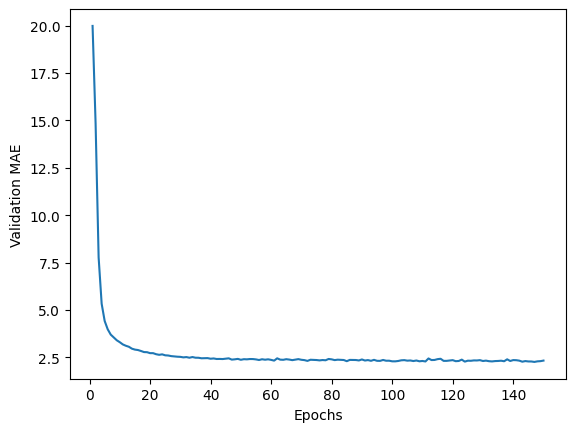

In [78]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

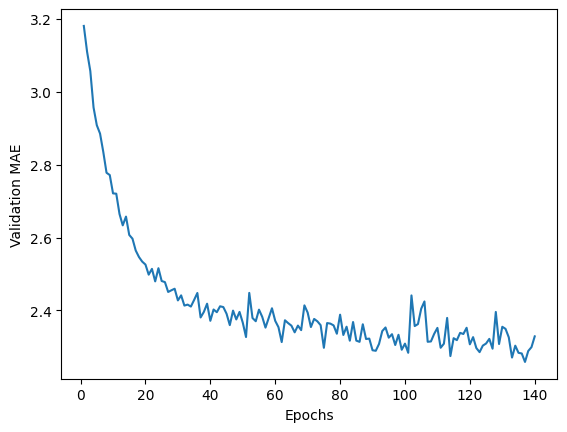

In [79]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [80]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 11.4031 - mae: 2.3048


In [81]:
test_mae_score

2.304758071899414

In [82]:
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 2ms/step


array([8.567794], dtype=float32)